# Looking at freezing rates in NorESM2

In [3]:
from imports import (
    np, pd, xr, plt, os, LinearRegression,
    metrics, sys, Axes3D)

import fnmatch
from functions import regress_1d, add_weights, masked_average

%matplotlib inline

In [4]:
host = os.uname()[1]
if 'jupyter' in host.split('-'): # Check if running on NIRD through the Jupyter Hub
    print('Running through MC2 Jupyter Hub')
    model_dir = '/mnt/mcc-ns9600k/jonahks/'
    os.chdir(model_dir)

else:  # Assume that we're running on a local machine and mounting NIRD
    print('Running on %s, attempting to mount ns9600k/jonahks/ from NIRD' % str(host))
    os.system('fusermount -zu ~/drivemount/')  # unmount first
    os.system('sshfs jonahks@login.nird.sigma2.no:"p/jonahks/" ~/drivemount/')    # Calling mountnird from .bashrc doesn't work
    os.chdir('/home/jonahks/drivemount/')
    save_dir = '~/DATAOUT/'
    save_to = os.path.expanduser(save_dir)

obs_dir = 'caliop_slfs/'
output_dir = 'figures/'
case_dir = 'mnth15runs/' # inconsistent label compared to jupy_test
    
# Check that each important directory can be accessed:    
access_paths = os.path.exists(obs_dir) and os.path.exists(output_dir) and os.path.exists(case_dir)
print('Can access all directory paths:', access_paths)

Running on storm.uio.no, attempting to mount ns9600k/jonahks/ from NIRD
Can access all directory paths: True


In [5]:
os.listdir('mnth15runs/')

['20191217_145440_singleparam_jolt_wbf_1_inp_1000',
 '20191128_171713_sampleparamset_wbf_10_inp_1',
 '20191209_180424_sampleparamset_wbf_1_inp_0.1',
 'error_vs_iso.png',
 'unused',
 '20191127_162007_sampleparamset_wbf_0.01_inp_1',
 'runs_as_vectors.png',
 '20191210_152149_sampleparamset_wbf_1_inp_0.1',
 '20191128_171713_sampleparamset_wbf_1_inp_10',
 '20191210_152149_sampleparamset_wbf_1_inp_10',
 '20191217_134307_singleparam_jolt_wbf_1_inp_0',
 'paramspace.png',
 '20191122_161009_sampleparamset_wbf_1_inp_1']

In [6]:
interest_cases = ['20191210_152149_sampleparamset_wbf_1_inp_0.1', 
                  '20191210_152149_sampleparamset_wbf_1_inp_10',
                  '20191217_134307_singleparam_jolt_wbf_1_inp_0',
                  '20191217_145440_singleparam_jolt_wbf_1_inp_1000']

In [7]:
dss = []
for i in interest_cases:
    _ds = xr.open_dataset('%s%s/%s.nc' % (case_dir, i, i))
    dss.append(_ds)

In [11]:
_ds['lev'][19]

<xarray.DataArray 'lev' ()>
array(445.9925741)
Coordinates:
    lev      float64 446.0
Attributes:
    standard_name:  atmosphere_hybrid_sigma_pressure_coordinate
    axis:           Z
    positive:       down
    long_name:      hybrid sigma pressure coordinate
    units:          hPa
    formula_terms:  ap: ap b: b ps: ps
    bounds:         lev_bnds

In [13]:
rate_list = ['DSTFREZCNT','DSTFREZDEP','DSTFREZIMM', 'MNUCCTO', 'MNUCCCO', 'NUMICE', 'gw', 'TS']
for i, k in zip(dss, interest_cases):
    _ds = i[rate_list]
    _ds = add_weights(_ds)
    _mask = _ds['lat']<70
    print(k + 'over 379-524 mPa')
    for j in rate_list[:-2]:
        _zone_mean = masked_average(_ds[j], dim=['lat','lon'], weights=_ds['cell_weight'], mask=_mask)
        _rate_avg = np.nanmean(_zone_mean.isel(lev=[18,19,20]))
#        _rate_avg = np.nanmean(_zone_mean)
        print('%s: %s' % (j, '{:.2e}'.format(_rate_avg)))

20191210_152149_sampleparamset_wbf_1_inp_0.1over 379-524 mPa
DSTFREZCNT: 1.62e-15
DSTFREZDEP: 1.27e-06
DSTFREZIMM: 4.52e-02
MNUCCTO: 5.53e-23
MNUCCCO: 5.67e-14
NUMICE: 8.61e+03
20191210_152149_sampleparamset_wbf_1_inp_10over 379-524 mPa
DSTFREZCNT: 3.03e-07
DSTFREZDEP: 2.74e-02
DSTFREZIMM: 5.15e+00
MNUCCTO: 7.92e-19
MNUCCCO: 3.90e-12
NUMICE: 8.85e+03
20191217_134307_singleparam_jolt_wbf_1_inp_0over 379-524 mPa
DSTFREZCNT: 0.00e+00
DSTFREZDEP: 0.00e+00
DSTFREZIMM: 0.00e+00
MNUCCTO: 0.00e+00
MNUCCCO: 0.00e+00
NUMICE: 9.01e+03
20191217_145440_singleparam_jolt_wbf_1_inp_1000over 379-524 mPa
DSTFREZCNT: 3.28e-10
DSTFREZDEP: 2.36e-04
DSTFREZIMM: 3.43e+02
MNUCCTO: 2.01e-17
MNUCCCO: 4.09e-11
NUMICE: 8.34e+03


20191210_152149_sampleparamset_wbf_1_inp_0.1over 379-524 mPa

DSTFREZCNT: 1.62e-15

DSTFREZDEP: 1.27e-06

DSTFREZIMM: 4.52e-02

MNUCCTO: 5.53e-23

MNUCCCO: 5.67e-14

NUMICE: 8.61e+03

20191210_152149_sampleparamset_wbf_1_inp_10over 379-524 mPa

DSTFREZCNT: 3.03e-07

DSTFREZDEP: 2.74e-02

DSTFREZIMM: 5.15e+00

MNUCCTO: 7.92e-19

MNUCCCO: 3.90e-12

NUMICE: 8.85e+03

20191217_134307_singleparam_jolt_wbf_1_inp_0over 379-524 mPa

DSTFREZCNT: 0.00e+00

DSTFREZDEP: 0.00e+00

DSTFREZIMM: 0.00e+00

MNUCCTO: 0.00e+00

MNUCCCO: 0.00e+00

NUMICE: 9.01e+03

20191217_145440_singleparam_jolt_wbf_1_inp_1000over 379-524 mPa

DSTFREZCNT: 3.28e-10

DSTFREZDEP: 2.36e-04

DSTFREZIMM: 3.43e+02

MNUCCTO: 2.01e-17

MNUCCCO: 4.09e-11

NUMICE: 8.34e+03

In [33]:
dss[0]['DSTFREZIMM']
for i in dss:
    i['DSTFREZIMM']

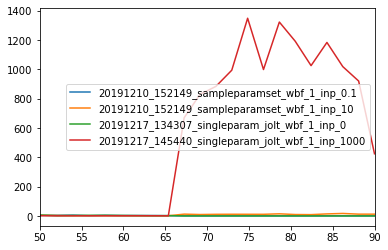

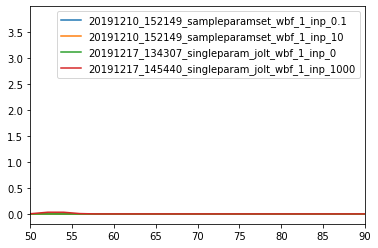

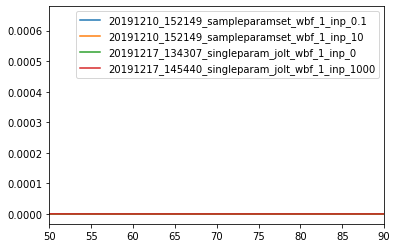

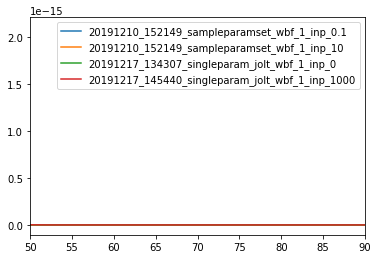

In [8]:
rate_list = ['DSTFREZIMM','DSTFREZDEP','DSTFREZCNT', 'MNUCCTO']

for j in rate_list:
    plt.figure()
    for k, name in zip(dss, interest_cases):
        _temp = k[j].isel(time=5, lev=19).mean(dim='lon') # June and 450 mPa

        plt.plot(_temp['lat'], _temp, label=name)
        plt.legend()
    plt.xlim((50,90))


In [39]:
_temp.isel(time=5, lev=19)

<xarray.DataArray 'DSTFREZCNT' (lat: 96, lon: 144)>
array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]], dtype=float32)
Coordinates:
    time     object 0001-07-01 00:00:00
  * lat      (lat) float64 -90.0 -88.11 -86.21 -84.32 ... 84.32 86.21 88.11 90.0
  * lon      (lon) float64 0.0 2.5 5.0 7.5 10.0 ... 350.0 352.5 355.0 357.5
    lev      float64 446.0
Attributes:
    long_name:     dust contact    freezing rate
    units:         m-3s-1
    mdims:         1
    cell_methods:  time: mean

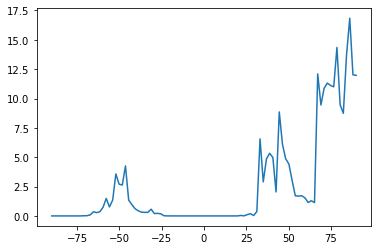

In [13]:
plt.plot(_temp['lat'], np.nanmean(_temp['DSTFREZIMM'], axis=1))

In [55]:
        _zone_mean = masked_average(_ds[j], dim=['lat','lon'], weights=rates['cell_weight'], mask=_mask)
#        _rate_avg = np.nanmean(_zone_mean.isel(lev=[18,19,20]))
        _rate_avg = np.nanmean(_zone_mean)
        print('%s produces average %s %s over 379-524 mPa' % (i, j, '{:.4e}'.format(_rate_avg)))

20191210_152149_sampleparamset_wbf_1_inp_0.1 produces average dst1_num 4.1132e+00 over 379-524 mPa
20191210_152149_sampleparamset_wbf_1_inp_0.1 produces average dst1_num_scaled 4.1090e+00 over 379-524 mPa
20191210_152149_sampleparamset_wbf_1_inp_0.1 produces average dst3_num 6.6354e-02 over 379-524 mPa
20191210_152149_sampleparamset_wbf_1_inp_0.1 produces average dst3_num_scaled 6.6352e-02 over 379-524 mPa
20191210_152149_sampleparamset_wbf_1_inp_10 produces average dst1_num 4.1132e+00 over 379-524 mPa
20191210_152149_sampleparamset_wbf_1_inp_10 produces average dst1_num_scaled 4.1090e+00 over 379-524 mPa
20191210_152149_sampleparamset_wbf_1_inp_10 produces average dst3_num 6.6354e-02 over 379-524 mPa
20191210_152149_sampleparamset_wbf_1_inp_10 produces average dst3_num_scaled 6.6352e-02 over 379-524 mPa


In [55]:
rate_list = ['dst1_num','dst1_num_scaled','dst3_num','dst3_num_scaled']
for i in interest_cases:
    _all = xr.open_dataset('%s%s/%s.nc' % (case_dir, i, i))
    _ds = _test[['dst1_num','dst1_num_scaled','dst3_num','dst3_num_scaled', 'gw', 'TS']]
    _ds = add_weights(_ds)
    _mask = rates['lat']>70
    for j in rate_list:
        _zone_mean = masked_average(_ds[j], dim=['lat','lon'], weights=rates['cell_weight'], mask=_mask)
#        _rate_avg = np.nanmean(_zone_mean.isel(lev=[18,19,20]))
        _rate_avg = np.nanmean(_zone_mean)
        print('%s produces average %s %s over 379-524 mPa' % (i, j, '{:.4e}'.format(_rate_avg)))

20191210_152149_sampleparamset_wbf_1_inp_0.1 produces average dst1_num 4.1132e+00 over 379-524 mPa
20191210_152149_sampleparamset_wbf_1_inp_0.1 produces average dst1_num_scaled 4.1090e+00 over 379-524 mPa
20191210_152149_sampleparamset_wbf_1_inp_0.1 produces average dst3_num 6.6354e-02 over 379-524 mPa
20191210_152149_sampleparamset_wbf_1_inp_0.1 produces average dst3_num_scaled 6.6352e-02 over 379-524 mPa
20191210_152149_sampleparamset_wbf_1_inp_10 produces average dst1_num 4.1132e+00 over 379-524 mPa
20191210_152149_sampleparamset_wbf_1_inp_10 produces average dst1_num_scaled 4.1090e+00 over 379-524 mPa
20191210_152149_sampleparamset_wbf_1_inp_10 produces average dst3_num 6.6354e-02 over 379-524 mPa
20191210_152149_sampleparamset_wbf_1_inp_10 produces average dst3_num_scaled 6.6352e-02 over 379-524 mPa


In [11]:
_test = xr.open_dataset('%s%s/%s.nc' % (case_dir, interest_cases[0], interest_cases[0]))

In [19]:
rates = _test[['BCFREZCNT','BCFREZDEP','BCFREZIMM', 'gw', 'TS']]
rates = add_weights(rates)

In [23]:
#_mask = np.bitwise_or(ds['lat']<_lowlat, ds['lat']>_highlat)
_mask = rates['lat']>70
zone_mean = masked_average(rates['BCFREZCNT'], dim=['lat','lon'], weights=rates['cell_weight'], mask=_mask)


In [36]:
np.nanmean(zone_mean.isel(lev=[18,19,20]))

1.0245191776039853e-08

In [28]:
np.nanmean(zone_mean)

1.0011513768894683e-09

In [25]:
zone_mean.plot(time=0)

ImportError: Plotting of arrays of cftime.datetime objects or arrays indexed by cftime.datetime objects requires the optional `nc-time-axis` (v1.2.0 or later) package.

In [ ]:
    df = pd.DataFrame()

    df['Isotherm'] = ds['isotherms_mpc'].values - 273.15
    df['NorESM_Average'] = 100*masked_average(ds['SLF_ISOTM_AVG'], dim=['lat','lon'], weights=ds['cell_weight'])

    # Add each latitude range from CALIOP
    for i in slf_files:
        _, _lowlat, _highlat = interpretNS(i)
        _mask = np.bitwise_or(ds['lat']<_lowlat, ds['lat']>_highlat)
        zone_mean = masked_average(ds['SLF_ISOTM_AVG'], dim=['lat','lon'], weights=ds['cell_weight'], mask=_mask)
        df['NorESM' + i[10:-4]] = 100*zone_mean

    df = df.set_index('Isotherm')

In [11]:
_test.variables

Frozen(OrderedDict([('time', <xarray.IndexVariable 'time' (time: 15)>
array([cftime.DatetimeNoLeap(1, 2, 1, 0, 0, 0, 0, 4, 32),
       cftime.DatetimeNoLeap(1, 3, 1, 0, 0, 0, 0, 4, 60),
       cftime.DatetimeNoLeap(1, 4, 1, 0, 0, 0, 0, 0, 91),
       cftime.DatetimeNoLeap(1, 5, 1, 0, 0, 0, 0, 2, 121),
       cftime.DatetimeNoLeap(1, 6, 1, 0, 0, 0, 0, 5, 152),
       cftime.DatetimeNoLeap(1, 7, 1, 0, 0, 0, 0, 0, 182),
       cftime.DatetimeNoLeap(1, 8, 1, 0, 0, 0, 0, 3, 213),
       cftime.DatetimeNoLeap(1, 9, 1, 0, 0, 0, 0, 6, 244),
       cftime.DatetimeNoLeap(1, 10, 1, 0, 0, 0, 0, 1, 274),
       cftime.DatetimeNoLeap(1, 11, 1, 0, 0, 0, 0, 4, 305),
       cftime.DatetimeNoLeap(1, 12, 1, 0, 0, 0, 0, 6, 335),
       cftime.DatetimeNoLeap(2, 1, 1, 0, 0, 0, 0, 2, 1),
       cftime.DatetimeNoLeap(2, 2, 1, 0, 0, 0, 0, 5, 32),
       cftime.DatetimeNoLeap(2, 3, 1, 0, 0, 0, 0, 5, 60),
       cftime.DatetimeNoLeap(2, 4, 1, 0, 0, 0, 0, 1, 91)], dtype=object)
Attributes:
    standard_name:  tim

In [ ]:
ds = xr.open_dataset(in_path + '.nc')
ds = add_weights(ds)